# 07 - Making and using hostart files

## Create a hotstart file to resume a simulation from given hydrological conditions

Hydrological models have state variables that describe the snow pack, soil moisture, underground reservoirs, etc. Typically, those cannot be measured empirically, so one way to estimate those values is to run the model for a period before the period we are actually interested in, and save the state variables at the end of this *warm-up* simulation.

This notebook shows how to save those state variables and use them to configure another Raven simulation. These *states* are configured by the `:HRUStateVariableTable` and `:BasinStateVariables` commands, but `ravenpy` has a convenience function `set_solution` to update those directly from the `solution.rvc` simulation output. 

In the following, we run the model on two years then save the final states. Next, we use those final states to configure the initial state of a second simulation over the next two years. If everything is done correctly, these two series should be identical to a simulation over the full four years. 

## Model configuration 

At this point the following block of code should be quite familiar! If not, please go back to notebook "04 - Emulating hydrological models" to understand what is happening.


In [2]:
import datetime as dt
import warnings

import xarray as xr
from matplotlib import pyplot as plt

from ravenpy import Emulator, RavenWarning
from ravenpy.new_config import commands as rc

# Import the GR4JCN model
from ravenpy.new_config.emulators import GR4JCN
from ravenpy.ravenpy import run

# Start and end date for full simulation
# Make sure the end date is before the end of the hydrometeorological data NetCDF file.
start_date = dt.datetime(1986, 1, 1)
end_date = dt.datetime(1988, 1, 1)

# Define HRU
hru = {}
hru = dict(
    area=4250.6,
    elevation=843.0,
    latitude=54.4848,
    longitude=-123.3659,
    hru_type="land",
)

# Set alternative names for netCDF variables
alt_names = {
    "TEMP_MIN": "tmin",
    "TEMP_MAX": "tmax",
    "PRECIP": "pr",
}

# Data types to extract from netCDF
data_type = ["TEMP_MAX", "TEMP_MIN", "PRECIP"]
data_kwds = {
    "ALL": {
        "elevation": hru["elevation"],
        "latitude": hru["latitude"],
        "longitude": hru["longitude"],
    }
}

# Model configuration
config = GR4JCN(
    params=[0.529, -3.396, 407.29, 1.072, 16.9, 0.947],
    Gauge=[
        rc.Gauge.from_nc(
            "ERA5_weather_data.nc",
            data_type=data_type,
            alt_names=alt_names,
            data_kwds=data_kwds,
        )
    ],
    HRUs=[hru],
    StartDate=start_date,
    EndDate=end_date,
    RunName="full",
    GlobalParameter={"AVG_ANNUAL_RUNOFF": 208.480},
)

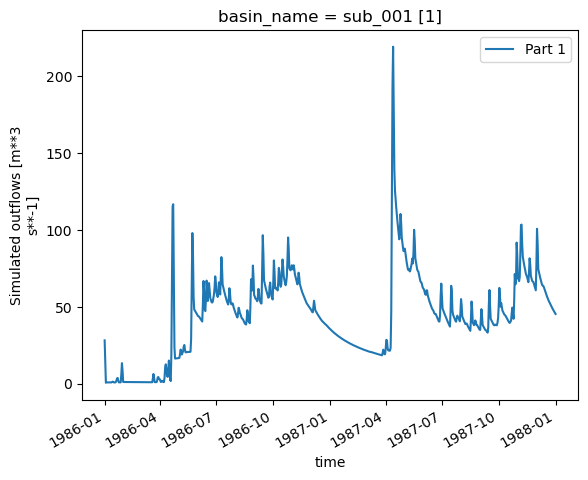

In [3]:
# Silence the Raven warnings
warnings.simplefilter("ignore", category=RavenWarning)

# Run the model and get the outputs.
out1 = Emulator(config=config).run()

# Plot the model output
out1.hydrograph.q_sim.plot(label="Part 1")
plt.legend()

### Now let's run the model for the next two years, setting the initial conditions to the final states of the first simulation. 

The path to the `solution.rvc` file can be found in `out1.files["solution"]`.
The content itself can be displayed with `out1.solution`

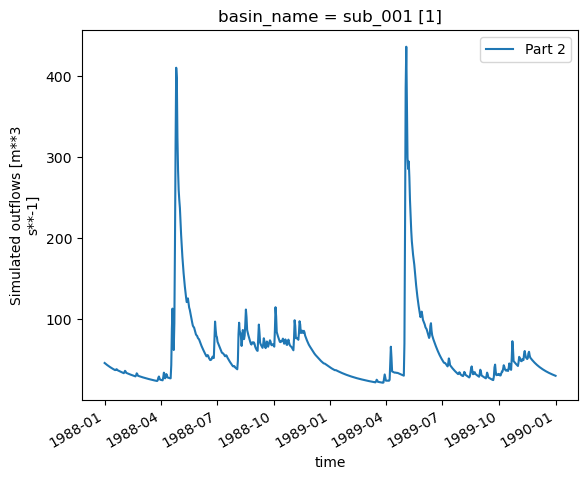

In [4]:
# The path to the solution (final model states)
hotstart = out1.files["solution"]

# Configure and run the model, this time with the next two years first 3 years (1988-1990).
conf2 = config.set_solution(hotstart)
conf2.start_date = dt.datetime(1988, 1, 1)
conf2.end_date = dt.datetime(1990, 1, 1)
conf2.run_name = "part_2"

out2 = Emulator(config=conf2).run()

# Plot the model output
out2.hydrograph.q_sim.plot(label="Part 2")
plt.legend()

## Compare with simulation over entire period

Now in theory, those two simulations should be identical to one simulation over the whole period of four years, let's confirm this. 

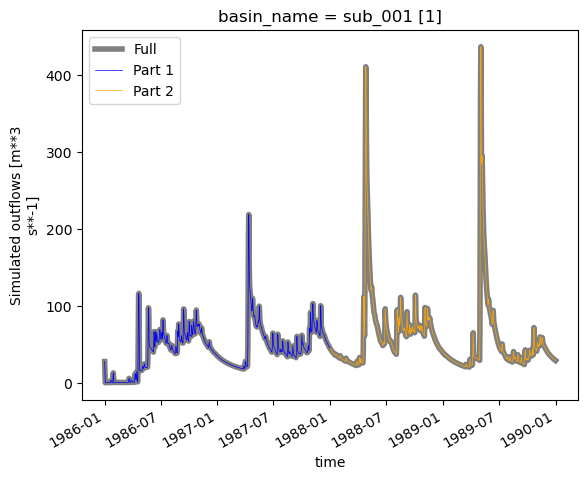

In [5]:
full = config.copy()
full.end_date = dt.datetime(1990, 1, 1)
full.run_name = "full"

out = Emulator(config=full).run(overwrite=True)

out.hydrograph.q_sim.plot(label="Full", color="gray", lw=4)
out1.hydrograph.q_sim.plot(
    label="Part 1",
    color="blue",
    lw=0.5,
)
out2.hydrograph.q_sim.plot(label="Part 2", color="orange", lw=0.5)
plt.legend()

And now if we look at the difference between both hydrographs, we can see that there are differences in the second part at machine precision levels, due to rounding in the hotstart file (note that the y-axis is 1e-6, which is essentially 0!). But the rest is perfect!

Therefore, we can provide forecasting abilities by saving simulation final states and using those to initialize model states for the forecasting runs. This will be used in other notebooks such as notebook #12 on hindcasting.

Text(0.5, 1.0, 'Difference between two parts and full simulation')

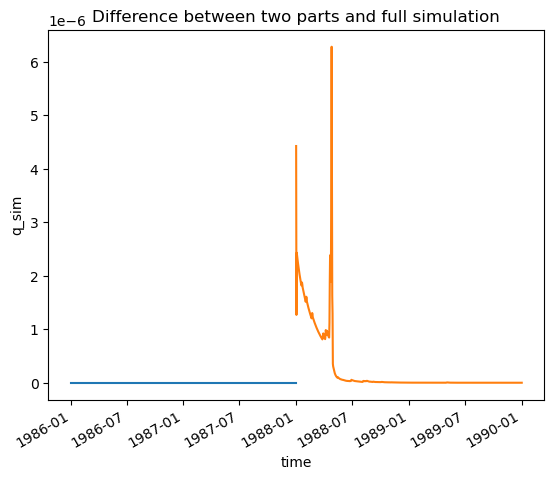

In [6]:
import numpy as np

delta1 = np.abs(out1.hydrograph.q_sim - out.hydrograph.q_sim)
delta2 = np.abs(out2.hydrograph.q_sim - out.hydrograph.q_sim)

delta1.plot(label="Part 1")
delta2.plot(label="Part 2")
plt.title("Difference between two parts and full simulation")